
# Random Forest (Régression) — Boston House Prices

**Objectif**  
Mettre en œuvre un modèle de Random Forest pour un problème de régression, comparer
les performances à une baseline simple, et analyser les résultats.

**Dataset**  
Boston House Prices (via `fetch_openml`)

**Librairies**  
scikit-learn, pandas, numpy, matplotlib, seaborn


In [1]:

# Installation (Colab uniquement)
# !pip install -q scikit-learn pandas numpy matplotlib seaborn


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 42



## 1. Chargement des données


In [3]:

# Chargement du dataset Boston Housing
boston = fetch_openml(name="boston", version=1, as_frame=True)

X = boston.data
y = boston.target.astype(float)

print(X.shape)
X.head()


(506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33



## 2. Exploration rapide


In [4]:

X.describe()


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000


In [5]:

print("Valeurs manquantes :")
print(X.isnull().sum())


Valeurs manquantes :
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64



## 3. Split Train / Validation / Test


In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)


(404, 13) (102, 13)



## 4. Baseline (Dummy Regressor)


In [8]:

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)

y_pred_base = baseline.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)
r2_base = r2_score(y_test, y_pred_base)

rmse_base, mae_base, r2_base


(np.float64(8.662876564628665), 6.255843525529023, -0.023340500652033302)


## 5. Random Forest Regressor


In [10]:

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, mae_rf, r2_rf


(8.510201343137252, 2.0413137254901947, 0.8839525117021145)


## 6. Recherche d'hyperparamètres (Grid Search)


In [11]:

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

grid.fit(X_train, y_train)

grid.best_params_


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


## 7. Validation croisée


In [12]:

cv_scores = cross_val_score(
    grid.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

np.mean(-cv_scores)


np.float64(3.8192771047909155)


## 8. Importance des variables


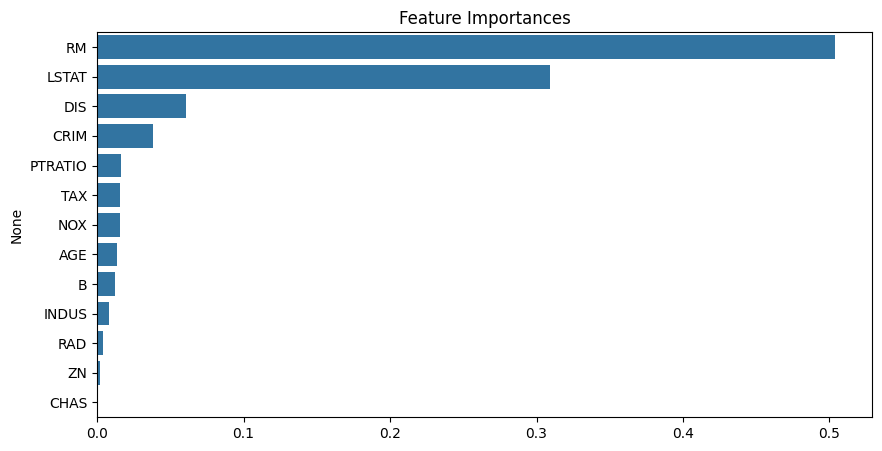

In [13]:

importances = pd.Series(
    grid.best_estimator_.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances")
plt.show()



## 9. Discussion & limites

- Dataset ancien et de petite taille  
- Risque d'overfitting malgré la validation croisée  
- Random Forest peu interprétable comparé à un modèle linéaire  
- Sensible au choix des hyperparamètres  

## Conclusion
Le Random Forest améliore nettement la baseline simple en termes de RMSE et R².



## Références
- scikit-learn documentation  
- Boston Housing Dataset (UCI / OpenML)
